# Outputting a weighted sum of inputs

In this tutorial, you will learn the fundamentals of using the provided neural network library for training a Moku Neural Network to deploy on Moku:Pro. This library uses the [Tensorflow](https://www.tensorflow.org/) implementation of [Keras](https://www.tensorflow.org/guide/keras) to instill best practices for deploying an FPGA-based neural network. In this example, we will train a basic model to output a weighted sum of the input chnnels with an optional bias/offset term using a single layer with a single neuron.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from moku.nn import LinnModel, save_linn

2025-11-17 10:49:19.372943: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-17 10:49:19.713194: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-17 10:49:21.364942: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


# Step 1: Generate input (3 channels) and output (one channel) data for training

Generate training data and plot the simulated signals to verify them. You can also choose to use Moku to produce training data.

Text(0.5, 1.0, 'Desired output')

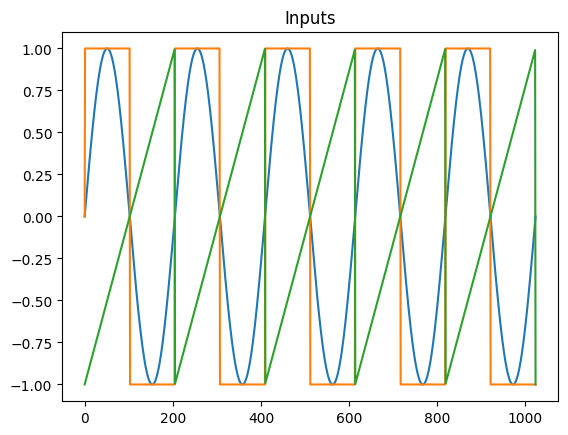

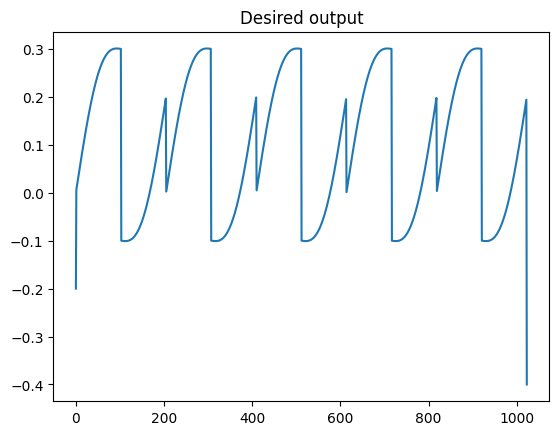

In [2]:
nPts = 1024
nCycles = 5
x = np.linspace(0, nCycles * 2 * np.pi, nPts)

in1 = np.sin(x)

in2 = np.sign(in1)

in3 = 1 / np.pi * ((x % (2 * np.pi)) - np.pi)

offset = 0.1
amp1 = 0.1
amp2 = 0.2
amp3 = 0.3

out = amp1 * in1 + amp2 * in2 + amp3 * in3 + offset

plt.figure()
plt.plot(in1)
plt.plot(in2)
plt.plot(in3)
plt.title('Inputs')

plt.figure()
plt.plot(out)
plt.title('Desired output')

# Step 2: Defining the model and train the neural network

Now that we have defined the training data we need to define a model which we will then subsequently train. A neural network is made of succesive layers of connected neurons that implement a generally non-linear mapping of a linear transform: $A(Wx + b)$, where $W$ is the weight matrix, $x$ is an input vector, $b$ is a bias vector and $A$ is the activation function. By successively stacking and connecting arbitrarily large numbers of artificial neurons, a neural network becomes a unviersal approximator. While there are many different types of neural networks, the Moku FPGA currently only supports densely connected feedforward networks. More information on these type of networks, otherwise known as multilayer perceptrons, can be found here: [Goodfellow-Ch6](https://www.deeplearningbook.org/contents/mlp.html).

We also reshape the data to reflect that we have N number of training examples of size 1. In general, training data should allow for the mapping $(N, M)\mapsto(N, K)$ where N is the number of training examples, M is the input feature dimension and K is the output feature dimension. In this case we are looking to map $X \mapsto Y$ where both X and Y have shape (N, 1).


In [3]:
# Reshape the inputs, ready for training. Each `data point' is three inputs and one output
inputs = np.vstack((in1, in2, in3)).transpose()  # Shape is now nPts x 3
out.shape = [nPts, 1]  # Shape is now nPts x 1

We need to define the model structure that we will use to represent the functional mapping. To do this, we will define a simple model with only one dense layer of a single neuron and a linear activation function. We provide a model definition as a list of tuples, where each tuple can take the form: `(layer_size, activation)`.

Build the neural network model. Skip the I/O scaling as the data is sufficient for training,
Note that if you add scaling here, you'll need to apply the same scaling in the Moku Neural Network instrument at
runtime.

In [4]:
linn_model = LinnModel()
linn_model.set_training_data(inputs, out, scale=False)

model_definition = [
    (1, 'linear')
]  # A linear model should give a perfect prediction in this contrived case
# Try some of the others below

# model_definition = [ (4, 'relu'), (4, 'relu')] # ReLU activation not great on signal reconstruction
# model_definition = [ (4, 'tanh'), (4, 'tanh')] # tanh has a range of +-1 which is more "voltage-like"
# model_definition = [ (16, 'tanh'), (16, 'tanh')] # A few more degrees of freedom to play around with
# model_definition = [ (100, 'tanh'), (100, 'tanh'), (100, 'tanh'), (100, 'tanh'), (100, 'tanh')] # Biggest Moku can fit, can overfit!

linn_model.construct_model(model_definition)

2025-11-17 10:49:21.937315: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Here we can see our dense layers that match the size that we defined. There are a number of intermediate layers listed as `output_clip_layer` which can be ignored. These layers are a byproduct of the quantisation for the Moku implmentation and are automatically added by the quantised model.

Now that we have defined our model, we need to train it so that it will represent our desired mapping. This is as simple as calling the `fit_model()` function with a few simple arguments. We will allow our model to train for 500 epochs (training steps) and will pass our validation data that we used earlier.

<div class="alert alert-block alert-info">
<b>Tip:</b> For those familiar with Keras, keyword arguments can be passed to the Keras 'fit' function via the 'fit_model' function.
</div>

In [5]:
# %%
# Train the model. This simple model converges quickly, so an early stopping config terminates training much more quickly.
history = linn_model.fit_model(epochs=500, validation_split=0.1, es_config={'patience': 10})

Value for monitor missing. Using default:val_loss.
Value for restore missing. Using default:False.


Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0406 - val_loss: 0.8079
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9201 - val_loss: 0.7448
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8035 - val_loss: 0.6792
Epoch 4/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6995 - val_loss: 0.6182
Epoch 5/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6074 - val_loss: 0.5555
Epoch 6/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5275 - val_loss: 0.5018
Epoch 7/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4575 - val_loss: 0.4517
Epoch 8/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3967 - val_loss: 0.4055
Epoch 9/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3440 - val_loss: 0.3641
Epoch 10/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2987 - val_loss: 0.3271
Epoch 11/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2596 - val_loss: 0.2938
Epoch 12/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2

We can use the returned history object to view the training and validation loss as a function of the training epochs. As training continues we can see that again the validation loss reduces and we end up with a model that has generalized to the training data.

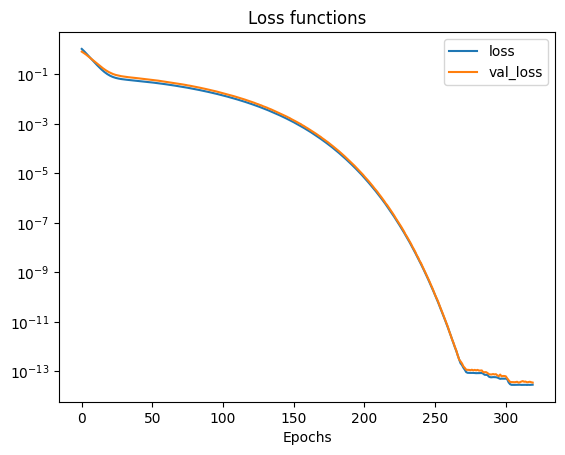

In [6]:
# plot the losses
plt.figure()
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.title('Loss functions')
plt.show()

Optionally, we can view the performance of our model on our data by plotting the models predictions. In general, training an accurate model will be a function of many variables including choice of activation function, number of layers, number of neurons and the structure of the training data.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


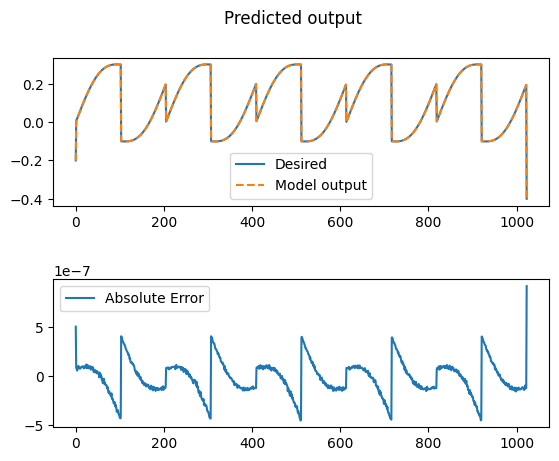

In [7]:
# %%
# Plot the error between the actual and predicted points
nn_out = linn_model.predict(inputs)
fig, axs = plt.subplots(2)
fig.suptitle('Predicted output')
axs[0].plot(out, label='Desired')
axs[0].plot(nn_out, '--', label='Model output')
axs[0].legend()
axs[1].plot(nn_out - out, label='Absolute Error')
axs[1].legend()
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

Note the scale on the plot mapping the difference between model output and desired output.

# Step 3: Save the model to disk for use in the Moku Neural Network instrument.

The neural network is completely described by its weights and biases. In this simple case, we can inspect these values and compare them to the function that was used to generate the data in the first place. Note that it has almost exactly learned the original function.

In [8]:
# Print model weights for interest and education
ii = 0
for layer in history.model.layers:
    if layer.get_weights():
        print(
            f'{ii}: ',
            'Weights',
            layer.get_weights()[0].flatten().tolist(),
            ', Biases',
            layer.get_weights()[1].flatten().tolist(),
        )
        ii = ii + 1

# Save the model to a .linn file
save_linn(linn_model.model, input_channels=3, output_channels=1, file_name='Sum.linn')

0:  Weights [0.10000021010637283, 0.19999957084655762, 0.299999475479126] , Biases [0.09999997913837433]


Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 6 cycles
